# Import Files  &  Libs

In [ ]:
from google.colab import drive
from google.colab import files
drive.mount("/content/gdrive", force_remount=True)
!cp /content/gdrive/MyDrive/Decathlon/project.zip /content/
!unzip -q /content/project.zip
!rm /content/project.zip
!mkdir /content/results

In [64]:
import numpy as np
import matplotlib.pyplot as plt

from model import curvegen
from dataset import dataset
from sklearn.neighbors import KNeighborsRegressor
import sklearn
import scipy
import tqdm
import os
from importlib import reload
reload(curvegen)
reload(dataset)

<module 'training.training_deconv' from 'c:\\Users\\Edouard\\github\\DecathlonTest\\training\\training_deconv.py'>

# Load Data

In [76]:
deconv_ds_train=dataset.Annual_construction_dataset()
with open('data_deconv_train.json', 'r') as f:
    deconv_ds_train.load_from_json(f)
deconv_ds_val=dataset.Annual_construction_dataset()
with open('data_deconv_val.json', 'r') as f:
    deconv_ds_val.load_from_json(f)
deconv_ds_train.set_data_for_training(False)
deconv_ds_val.set_data_for_training(False)

# Model

In [ ]:
X_train=[]
Y_train=[]
X_val=[]
Y_val=[]
for sample in deconv_ds_train.samples_dep_73:
    Y_train.append(sample[0])
    X_train.append(sample[1])
X_train=np.array(X_train)
Y_train=np.array(Y_train)
for sample in deconv_ds_val.samples_dep_73:
    Y_val.append(sample[0])
    X_val.append(sample[1])
X_val=np.array(X_val)
Y_val=np.array(Y_val)
def custom_distance(x,y,w):
    cat1_x=x[0:8]
    cat2_x=x[8:29+8]
    cat3_x=x[29+8:]
    cat1_y=y[0:8]
    cat2_y=y[8:29+8]
    cat3_y=y[29+8:]
    cat1_d=w[0]*scipy.spatial.distance.minkowski(cat1_x, cat1_y, p=2, w=None)*(1/np.sqrt(2))
    cat2_d=w[1]*scipy.spatial.distance.minkowski(cat2_x, cat2_y, p=2, w=None)*(1/np.sqrt(2))
    cat3_d=scipy.spatial.distance.minkowski(cat3_x, cat3_y, p=2, w=None)
    return cat1_d+cat2_d+cat3_d
results=[]
gt=Y_val
for k in tqdm.tqdm(range(1,20)):
    for w1 in np.linspace(0,1,10):
        for w2 in np.linspace(0,1,10):
            for weight in ['uniform','distance']:
                knn = KNeighborsRegressor(n_neighbors=k,weights=weight,n_jobs=-1,metric=lambda a,b:custom_distance(a,b,np.array([w1,w2])))
                knn.fit(X_train, Y_train)
                pred=knn.predict(X_val)
                for n in range(len(pred)):
                    pred[n]=dataset.norm(pred[n],np.max(pred[n]),np.min(pred[n]))
                cosine_loss=sklearn.metrics.pairwise.cosine_similarity(pred,gt)
                l1_loss=sklearn.metrics.mean_absolute_error(pred,gt)
                l2_loss=sklearn.metrics.mean_squared_error(pred,gt)
                results.append({
                    "w":[w1,w2],
                    "k":k,
                    "weight":weight,
                    "cos_loss":cosine_loss,
                    "l1_loss":l1_loss,
                    "l2_loss":l2_loss
                })


In [ ]:
key=""
loss_list=[]
for result in results:
    loss_list.append(result[key])
min_loss_index=np.argmin(loss_list)
min_loss=loss_list[min_loss_index]
best_param=results[min_loss_index]
print("w = {} \t || k = {} \t || loss = {}".format(best_param["w"],best_param["k"],min_loss))

In [81]:
np.argmin(np.array([1,0,2]))

1

[[0.90841629]]


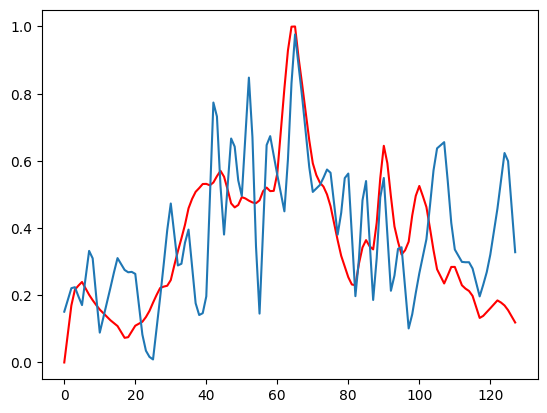

In [66]:
n=15
#print(torch.nn.CosineSimilarity()(torch.Tensor(dataset.norm(pred[n],np.max(pred[n]),np.min(pred[n]))).unsqueeze(0),torch.Tensor(gt[n]).unsqueeze(0)))
print(sklearn.metrics.pairwise.cosine_similarity(dataset.norm(pred[n],np.max(pred[n]),np.min(pred[n])).reshape(1, -1),gt[n].reshape(1, -1)))
print(sklearn.metrics.pairwise.cosine_similarity(dataset.norm(pred[n],np.max(pred[n]),np.min(pred[n])).reshape(1, -1),gt[n].reshape(1, -1)))
plt.plot(dataset.norm(pred[n],np.max(pred[n]),np.min(pred[n])),color='red')
plt.plot(gt[n])
plt.show()